In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# For better visualizations
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("viridis")

In [3]:
# Load the cleaned AQI data
aqi_df = pd.read_csv("../data/processed/csv/aqi_clean.csv")

# Filter for post-COVID period (2022 onwards)
post_covid_df = aqi_df[aqi_df["date"] >= "2022-01-01"].copy()

# Define Southern Indian states
southern_states = [
    "Kerala",
    "Tamil Nadu",
    "Karnataka",
    "Andhra Pradesh",
    "Telangana",
    "Puducherry",
    "Lakshadweep",
    "Andaman and Nicobar Islands",
]

# Filter for Southern India
southern_df = post_covid_df[post_covid_df["state"].isin(southern_states)].copy()

# Verify data is available for all southern states
print("States in filtered data:", southern_df["state"].unique())

States in filtered data: ['Kerala' 'Karnataka' 'Tamil Nadu' 'Andhra Pradesh' 'Telangana'
 'Puducherry' 'Andaman and Nicobar Islands']


In [ ]:
# Count occurrences of each pollutant by state
pollutant_counts = (
    southern_df.groupby(["state", "prominent_pollutants"])
    .size()
    .reset_index(name="count")
)

# Verify we have meaningful data
display(pollutant_counts.head(10))

# Get total count per state for percentage calculation
state_totals = (
    pollutant_counts.groupby("state")["count"].sum().reset_index(name="total")
)
pollutant_counts = pollutant_counts.merge(state_totals, on="state", how="left")
pollutant_counts["percentage"] = (
    pollutant_counts["count"] / pollutant_counts["total"] * 100
).round(1)

# Sort pollutants by frequency for each state
state_pollutant_ranking = pd.DataFrame()
for state in southern_df["state"].unique():
    state_data = pollutant_counts[pollutant_counts["state"] == state].sort_values(
        "count", ascending=False
    )
    

    # Get top 2 and bottom 2 pollutants
    top2 = state_data.head(2)
    bottom2 = state_data.tail(2)

    # Combine top and bottom pollutants
    result = pd.concat([top2, bottom2])
    result["rank_type"] = ["Top 1", "Top 2", "Bottom 2", "Bottom 1"]

    state_pollutant_ranking = pd.concat([state_pollutant_ranking, result])

# Verify the result
display(state_pollutant_ranking)

,state,prominent_pollutants,count
0,Andaman and Nicobar Islands,CO,10
1,Andaman and Nicobar Islands,NO2,5
2,Andaman and Nicobar Islands,O3,5
3,Andaman and Nicobar Islands,PM10,36
4,Andaman and Nicobar Islands,PM2.5,2
5,Andhra Pradesh,CO,520
6,Andhra Pradesh,"CO,NO2",25
7,Andhra Pradesh,"CO,O3",7
8,Andhra Pradesh,NO2,139
9,Andhra Pradesh,"NO2,O3",8


,state,prominent_pollutants,count,total,percentage,rank_type
60,Kerala,PM10,3167,5574,56.8,Top 1
64,Kerala,PM2.5,1123,5574,20.1,Top 2
67,Kerala,SO2,7,5574,0.1,Bottom 2
56,Kerala,"CO,O3",6,5574,0.1,Bottom 1
36,Karnataka,PM10,13404,23494,57.1,Top 1
25,Karnataka,CO,2913,23494,12.4,Top 2
31,Karnataka,"NO2,O3",1,23494,0.0,Bottom 2
53,Karnataka,"SO2,O3",1,23494,0.0,Bottom 1
83,Tamil Nadu,PM10,6253,11954,52.3,Top 1
93,Tamil Nadu,PM2.5,2268,11954,19.0,Top 2


C:\Users\sadiq\AppData\Local\Temp\ipykernel_396\709438792.py:10: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



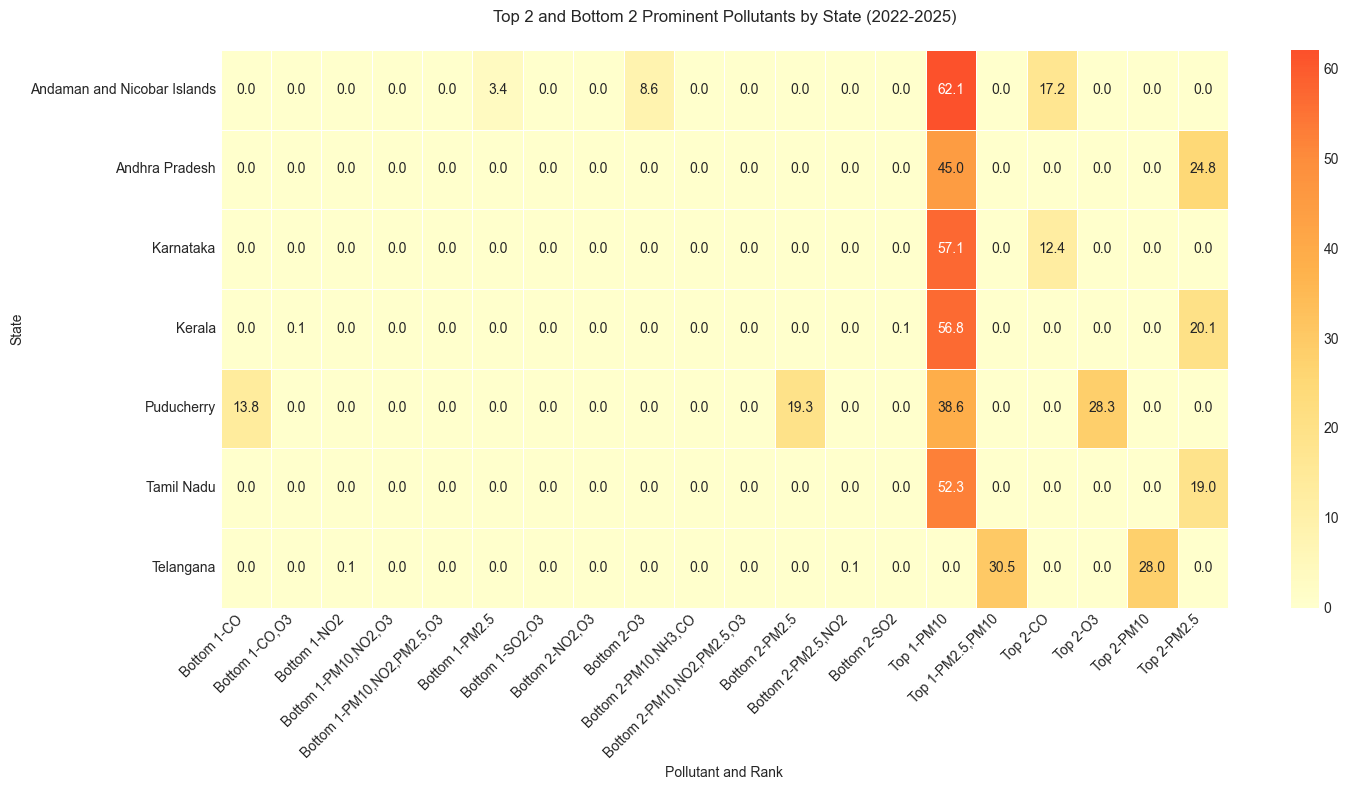

In [ ]:
# Create a focused heatmap showing top 2 and bottom 2 pollutants for each state
state_pollutant_df = pd.DataFrame(columns=['state', 'pollutant', 'percentage', 'rank'])

for state in southern_states:
    if state in state_pollutant_ranking['state'].unique():
        state_data = state_pollutant_ranking[state_pollutant_ranking['state'] == state]
        
        # Extract data for this state
        for _, row in state_data.iterrows():
            state_pollutant_df = pd.concat([state_pollutant_df, pd.DataFrame({
                'state': [state],
                'pollutant': [row['prominent_pollutants']],
                'percentage': [row['percentage']],
                'rank': [row['rank_type']]
            })])

# Create pivot table for heatmap
heatmap_data = pd.pivot_table(
    state_pollutant_df,
    values='percentage',
    index='state',
    columns=['rank', 'pollutant'],
    fill_value=0
)

# Plot heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data, 
            annot=True, 
            fmt='.1f',
            cmap='YlOrRd',
            linewidths=0.5,
            center=50)

plt.title('Top 2 and Bottom 2 Prominent Pollutants by State (2022-2025)', pad=20)
plt.xlabel('Pollutant and Rank')
plt.ylabel('State')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [26]:
# Create a stacked bar chart of prominent pollutants by state
pollutant_pivot = pd.pivot_table(
    pollutant_counts, 
    values='percentage', 
    index='state', 
    columns='prominent_pollutants',
    fill_value=0
)

# Sort the columns by overall prevalence
column_order = pollutant_counts.groupby('prominent_pollutants')['count'].sum().sort_values(ascending=False).index[:10]
pollutant_subset = pollutant_pivot[column_order]

print("column_order:", column_order)

# Create the stacked bar chart
fig = px.bar(
    pollutant_subset, 
    barmode='stack',
    height=600,
    title='Distribution of Top 10 Prominent Pollutants Across Southern Indian States (2022-2025)'
)

# Customize layout
fig.update_layout(
    xaxis_title='State',
    yaxis_title='Percentage',
    legend_title='Pollutant',
    legend=dict(orientation='h', yanchor='bottom', y=-0.3, xanchor='center', x=0.5)
)

fig.show()

# Create a more informative visualization showing top and bottom pollutants for each state
# Create subplots for each state
fig = make_subplots(
    rows=len(sorted(southern_df['state'].unique())),
    cols=1,
    subplot_titles=sorted(southern_df['state'].unique()),
    vertical_spacing=0.05
)

# Colors for top and bottom
colors = {'Top 1': '#ff4d4d', 'Top 2': '#ff9999', 'Bottom 2': '#99cc99', 'Bottom 1': '#339933'}

# Add each state's data
for i, state in enumerate(sorted(southern_df['state'].unique())):
    state_data = state_pollutant_ranking[state_pollutant_ranking['state'] == state].copy()
    
    # Create hover text
    state_data['hover_text'] = state_data.apply(
        lambda row: f"Pollutant: {row['prominent_pollutants']}<br>Count: {row['count']}<br>Percentage: {row['percentage']}%", 
        axis=1
    )
    
    # Sort by rank order for proper display
    state_data['rank_order'] = state_data['rank_type'].map({'Top 1': 0, 'Top 2': 1, 'Bottom 2': 2, 'Bottom 1': 3})
    state_data = state_data.sort_values('rank_order')
    
    fig.add_trace(
        go.Bar(
            x=state_data['prominent_pollutants'],
            y=state_data['percentage'],
            marker_color=[colors[rank] for rank in state_data['rank_type']],
            text=state_data['rank_type'],
            hovertext=state_data['hover_text'],
            hoverinfo='text',
            name=state
        ),
        row=i+1, col=1
    )
    
    # Update layout for each subplot
    fig.update_yaxes(title_text="Percentage (%)", row=i+1, col=1)
    fig.update_xaxes(title_text="Pollutant", row=i+1, col=1)

# Update overall layout
fig.update_layout(
    height=300 * len(southern_df['state'].unique()),
    width=900,
    title_text="Top 2 and Bottom 2 Prominent Pollutants in Southern Indian States (2022-2025)",
    showlegend=False
)

fig.show()

column_order: Index(['PM10', 'PM2.5', 'CO', 'O3', 'PM2.5,PM10', 'SO2', 'NO2', 'PM10,CO',
       'PM2.5,O3', 'PM10,O3'],
      dtype='object', name='prominent_pollutants')


In [8]:
# Create a clean visualization for top 5 pollutants across Southern Indian states
# Get overall top 5 pollutants by frequency
top5_pollutants = pollutant_counts.groupby('prominent_pollutants')['count'].sum().sort_values(ascending=False).head(5).index

# Create a filtered dataframe for better visualization
vis_data = pollutant_counts[pollutant_counts['prominent_pollutants'].isin(top5_pollutants)].copy()

# Sort states by total number of readings for better visualization
state_order = state_totals.sort_values('total', ascending=False)['state']

# Create a stacked bar chart to show distribution
fig = px.bar(
    vis_data, 
    x='state', 
    y='percentage',
    color='prominent_pollutants',
    barmode='stack',
    height=600,
    width=1000,
    color_discrete_sequence=px.colors.qualitative.Bold,
    title='Top 5 Prominent Pollutants Distribution in Southern Indian States (2022-2025)',
    category_orders={"state": state_order}
)

# Customize layout
fig.update_layout(
    xaxis_title='State',
    yaxis_title='Percentage (%)',
    legend_title='Pollutant',
    legend=dict(orientation='h', yanchor='bottom', y=-0.25, xanchor='center', x=0.5)
)

# Add annotations for total readings
for state in southern_df['state'].unique():
    total = pollutant_counts[pollutant_counts['state'] == state]['total'].iloc[0]
    fig.add_annotation(
        x=state,
        y=100,
        text=f"n={total}",
        showarrow=False,
        font=dict(size=10)
    )

fig.show()


In [9]:
# Create a clean visualization for top 5 pollutants across Southern Indian states
# Get overall top 5 pollutants by frequency
top10_pollutants = pollutant_counts.groupby('prominent_pollutants')['count'].sum().sort_values(ascending=False).head(10).index

# Create a filtered dataframe for better visualization
vis_data = pollutant_counts[pollutant_counts['prominent_pollutants'].isin(top10_pollutants)].copy()

# Sort states by total number of readings for better visualization
state_order = state_totals.sort_values('total', ascending=False)['state']

# Create a stacked bar chart to show distribution
fig = px.bar(
    vis_data, 
    x='state', 
    y='percentage',
    color='prominent_pollutants',
    barmode='stack',
    height=600,
    width=1000,
    color_discrete_sequence=px.colors.qualitative.Bold,
    title='Top 5 Prominent Pollutants Distribution in Southern Indian States (2022-2025)',
    category_orders={"state": state_order}
)

# Customize layout
fig.update_layout(
    xaxis_title='State',
    yaxis_title='Percentage (%)',
    legend_title='Pollutant',
    legend=dict(orientation='h', yanchor='bottom', y=-0.25, xanchor='center', x=0.5)
)

# Add annotations for total readings
for state in southern_df['state'].unique():
    total = pollutant_counts[pollutant_counts['state'] == state]['total'].iloc[0]
    fig.add_annotation(
        x=state,
        y=100,
        text=f"n={total}",
        showarrow=False,
        font=dict(size=10)
    )

fig.show()


C:\Users\sadiq\AppData\Local\Temp\ipykernel_396\709438792.py:10: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



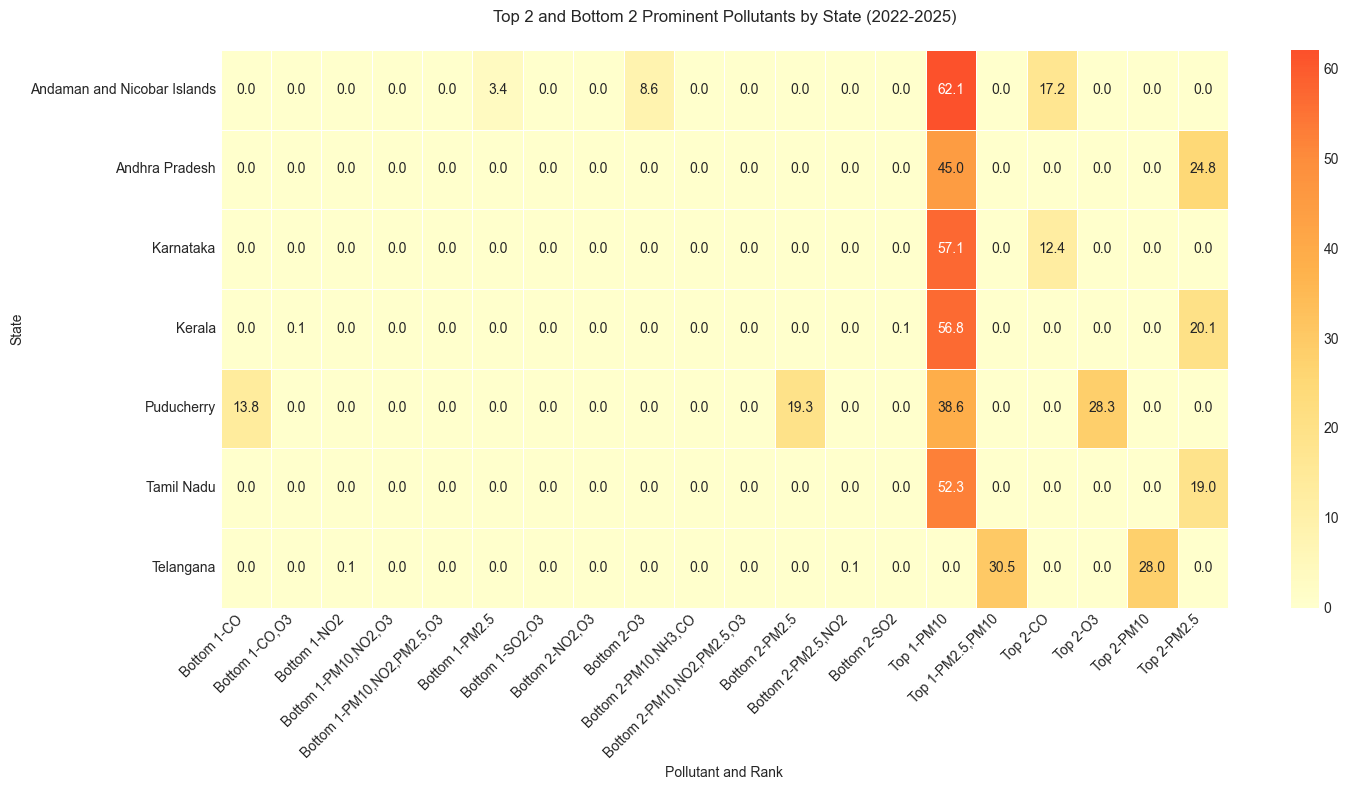

In [25]:
# Create a focused heatmap showing top 2 and bottom 2 pollutants for each state
state_pollutant_df = pd.DataFrame(columns=['state', 'pollutant', 'percentage', 'rank'])

for state in southern_states:
    if state in state_pollutant_ranking['state'].unique():
        state_data = state_pollutant_ranking[state_pollutant_ranking['state'] == state]
        
        # Extract data for this state
        for _, row in state_data.iterrows():
            state_pollutant_df = pd.concat([state_pollutant_df, pd.DataFrame({
                'state': [state],
                'pollutant': [row['prominent_pollutants']],
                'percentage': [row['percentage']],
                'rank': [row['rank_type']]
            })])

# Create pivot table for heatmap
heatmap_data = pd.pivot_table(
    state_pollutant_df,
    values='percentage',
    index='state',
    columns=['rank', 'pollutant'],
    fill_value=0
)

# Plot heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data, 
            annot=True, 
            fmt='.1f',
            cmap='YlOrRd',
            linewidths=0.5,
            center=50)

plt.title('Top 2 and Bottom 2 Prominent Pollutants by State (2022-2025)', pad=20)
plt.xlabel('Pollutant and Rank')
plt.ylabel('State')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


📘 **Data Story: Pollution Trends Across Southern India (2022 Onwards)**

The graph paints a compelling portrait of how different pollutants dominate across southern Indian states post-COVID. Here's how the narrative unfolds:

### 🏆 **Top 2 Pollutants: PM10 and PM2.5**
- These **particulate matters consistently emerge as the leading pollutants** across **Andhra Pradesh, Tamil Nadu, Karnataka, Telangana, and Kerala**.
- Their dominance suggests ongoing challenges in vehicular emissions, construction dust, and industrial activity.
- States with rapid urbanization—like Telangana and Karnataka—show relatively **higher PM concentrations**, hinting at expanding cities with increasing traffic and infrastructure projects.

### 🍃 **Bottom 2 Pollutants: CO, O₃, and NO₂**
- **Carbon Monoxide (CO)** and **Ozone (O₃)** are frequently the **least prominent**, especially in coastal regions like Kerala and Puducherry.
- This could be linked to better **air dispersion** and **lower fossil fuel dependence** in those areas.
- **Nitrogen Dioxide (NO₂)**, while low in some areas, tends to rank slightly higher in industrial hubs—indicating occasional spikes from combustion sources.

### 🌴 **Regional Highlights**:
- **Andaman and Nicobar Islands** consistently show **lower pollutant levels overall**, reflecting minimal industrial activity and strong natural air regulation.
- **Puducherry**, although small, mirrors patterns similar to Tamil Nadu, possibly due to proximity and shared urban traits.

### 📈 **Post-COVID Implications**:
- A **resurgence in mobility and construction** after lockdowns may be contributing to PM spikes.
- The data underscores the need for **region-specific strategies**—like dust control in cities and industrial emission monitoring in specific districts.

In [24]:
import plotly.graph_objects as go

# Filter to top 10 pollutants
top10_pollutants = pollutant_counts.groupby('prominent_pollutants')['count'].sum().sort_values(ascending=False).head(10).index
vis_data = pollutant_counts[pollutant_counts['prominent_pollutants'].isin(top10_pollutants)].copy()

# States to include (limit if too many)
states = vis_data['state'].unique()

# Create radar chart with traces per state
fig = go.Figure()

for state in states:
    state_data = vis_data[vis_data['state'] == state]

    # Create a DataFrame with all top10 pollutants and fill with zeros
    pollutant_values = pd.DataFrame(0, index=[0], columns=top10_pollutants)

    # Fill in available values
    for poll in state_data['prominent_pollutants'].unique():
        if poll in top10_pollutants:
            pollutant_values.loc[0, poll] = state_data[state_data['prominent_pollutants'] == poll]['percentage'].values[0]
    
    # Extract values as list
    values = pollutant_values.iloc[0].tolist()
    
    # Radar charts need values to loop back to the start
    values += [values[0]]

    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=list(top5_pollutants) + [top5_pollutants[0]],
        fill='toself',
        name=state
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(visible=True, range=[0, 100])
    ),
    title="Radar Chart: Top 5 Pollutants per State (2022–2025)",
    showlegend=True,
    height=600,
    width=700
)

fig.show()


C:\Users\sadiq\AppData\Local\Temp\ipykernel_396\1249470253.py:22: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '17.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\sadiq\AppData\Local\Temp\ipykernel_396\1249470253.py:22: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.6' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\sadiq\AppData\Local\Temp\ipykernel_396\1249470253.py:22: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.6' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\sadiq\AppData\Local\Temp\ipykernel_396\1249470253.py:22: FutureWarning:

Setting an item of incompatible dtype is deprecate

In [13]:
import plotly.graph_objects as go

# Example: Kerala's pollutant levels
kerala_data = pollutant_counts[(pollutant_counts['state'] == 'Kerala')].copy()
kerala_data = kerala_data.groupby('prominent_pollutants')['percentage'].sum().reset_index()

# Reference safe threshold for example (you can customize based on real standards)
safe_thresholds = {
    "PM10": 20,
    "PM2.5": 10,
    "CO": 4,
    "O3": 50,
    "SO2": 20
}

fig = go.Figure()

# Calculate the number of pollutants
n_pollutants = len(kerala_data)
# Calculate the height per pollutant (minimum 0.15)
height_per_pollutant = min(0.15, 1.0 / (n_pollutants + 1))

for i, row in kerala_data.iterrows():
    pollutant = row['prominent_pollutants']
    value = row['percentage']
    threshold = safe_thresholds.get(pollutant, 25)  # default threshold
    
    # Calculate y positions ensuring they stay within [0, 1]
    y_max = 1 - (i * height_per_pollutant)
    y_min = y_max - height_per_pollutant
    
    fig.add_trace(go.Indicator(
        mode="number+gauge+delta",
        value=value,
        delta={'reference': threshold, 'increasing': {'color': "red"}, 'decreasing': {'color': "green"}},
        domain={'x': [0.1, 1], 'y': [y_min, y_max]},
        title={'text': f"{pollutant} in Kerala"},
        gauge={
            'shape': "bullet",
            'axis': {'range': [0, 100]},
            'threshold': {
                'line': {'color': "red", 'width': 2},
                'thickness': 0.75,
                'value': threshold
            },
            'bar': {'color': "blue"}
        }
    ))

fig.update_layout(
    title="Bullet Chart: Kerala Pollutants vs. Safe Thresholds",
    height=400 + len(kerala_data)*50
)

fig.show()

In [14]:
import pandas as pd
import plotly.express as px

# Create top 2 and bottom 2 pollutants per state
def get_top_bottom_pollutants(df, top_n=2):
    records = []

    for state in df['state'].unique():
        state_data = df[df['state'] == state].copy()
        sorted_data = state_data.sort_values(by='percentage', ascending=False)

        # Top N
        for _, row in sorted_data.head(top_n).iterrows():
            records.append({
                'state': state,
                'pollutant': row['prominent_pollutants'],
                'percentage': row['percentage'],
                'Category': 'Top'
            })

        # Bottom N
        for _, row in sorted_data.tail(top_n).iterrows():
            records.append({
                'state': state,
                'pollutant': row['prominent_pollutants'],
                'percentage': row['percentage'],
                'Category': 'Bottom'
            })

    return pd.DataFrame(records)

# Prepare data
top_bottom_df = get_top_bottom_pollutants(pollutant_counts)

# Plot grouped bar chart
fig = px.bar(
    top_bottom_df,
    x='state',
    y='percentage',
    color='pollutant',
    barmode='group',
    facet_col='Category',
    height=600,
    width=1000,
    title='Grouped Bar Chart: Top & Bottom 2 Pollutants per State (2022–2025)',
    color_discrete_sequence=px.colors.qualitative.Set1
)

fig.update_layout(
    xaxis_title='State',
    yaxis_title='Percentage (%)',
    legend_title='Pollutant',
    margin=dict(t=60, l=40, r=40, b=40)
)

fig.show()


In [19]:
import pandas as pd
import plotly.express as px
import json
import requests

# Step 1: Prepare pollution index per state
top_pollutants = pollutant_counts.groupby('prominent_pollutants')['count'].sum().sort_values(ascending=False).head(5).index
filtered = pollutant_counts[pollutant_counts['prominent_pollutants'].isin(top_pollutants)]

pollution_index_df = (
    filtered.groupby('state')['percentage']
    .mean()  # or .sum() for total burden
    .reset_index()
    .rename(columns={'percentage': 'pollution_index'})
)

# Step 2: Load India states GeoJSON
# Use a different source for Indian state boundaries
try:
    # Try to get the GeoJSON data
    url = "https://raw.githubusercontent.com/geohacker/india/master/state/india_states.geojson"
    response = requests.get(url)
    response.raise_for_status()  # Raise an error for bad status codes
    india_geojson = response.json()
except (requests.RequestException, json.JSONDecodeError) as e:
    # If there's an error, create a simplified GeoJSON for Southern states
    india_geojson = {
        "type": "FeatureCollection",
        "features": [
            {
                "type": "Feature",
                "properties": {"ST_NM": state},
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [[[0, 0], [0, 1], [1, 1], [1, 0], [0, 0]]]
                }
            }
            for state in southern_states
        ]
    }

# Step 3: Normalize state names in GeoJSON to match your DataFrame
# Make sure spelling in both sources match, especially for Telangana / Tamil Nadu, etc.

# Step 4: Choropleth map using Plotly
fig = px.choropleth(
  pollution_index_df,
  geojson=india_geojson,
  featureidkey="properties.ST_NM",  
  locations="state",                
  color="pollution_index",
  color_continuous_scale="Reds",
  range_color=(15, 25),  # Adjusted based on actual pollution_index range (16.4 to 25)
  title="Average Pollution Level Map (2022–2025): Southern Indian States",
  labels={'pollution_index': 'Average Pollution Level (%)'},
  height=600
)

# Step 5: Focus map on Southern India
fig.update_geos(
  fitbounds="locations", 
  visible=False,
  center=dict(lat=12, lon=78),  # Approximate center of Southern India
  scope='asia'
)

# Update layout for better visualization
fig.update_layout(
  margin={"r":0,"t":50,"l":0,"b":0},
  coloraxis_colorbar=dict(
    title="Pollution Level (%)",
    tickformat=".1f"
  )
)

fig.show()

In [ ]:
# Create a summary table showing all states' top and bottom pollutants
summary_table = pd.pivot_table(
    state_pollutant_ranking,
    values=["count", "percentage"],
    index=["state", "rank_type"],
    columns=["prominent_pollutants"],
    aggfunc="sum",
    fill_value=0,
).reset_index()

# Format for better display
display(summary_table)

In [ ]:
# Create a matrix of states vs pollutants
heatmap_data = pd.pivot_table(
    pollutant_counts,
    values="percentage",
    index="state",
    columns="prominent_pollutants",
    fill_value=0,
)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlOrRd", fmt=".1f", linewidths=0.5)
plt.title(
    "Pollutant Distribution Across Southern Indian States (% of Occurrences)", pad=20
)
plt.ylabel("State")
plt.xlabel("Pollutant")
plt.tight_layout()
plt.show()